In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import xgboost as xgb

In [25]:
df = pd.read_csv('C:/Users/adars/Desktop/End-to-end projects/Sentiment-analysis/data/youtube_comments.csv')

In [27]:
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


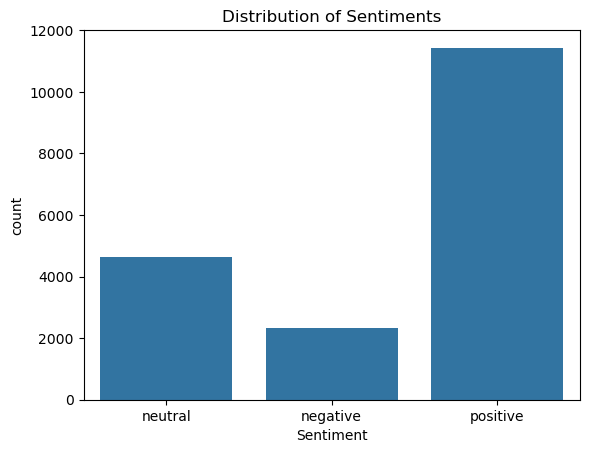

Sentiment
positive    0.621034
neutral     0.251956
negative    0.127010
Name: proportion, dtype: float64


In [29]:
sns.countplot(x="Sentiment", data=df)
plt.title("Distribution of Sentiments")
plt.show()

print(df["Sentiment"].value_counts(normalize=True))

In [30]:
df.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [31]:
df.dropna(inplace=True)

In [32]:
le = LabelEncoder()
df["encoded_sentiment"] = le.fit_transform(df["Sentiment"])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    df["Comment"], df["encoded_sentiment"], test_size=0.2, random_state=42
)

In [38]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_train_vec2 = embedder.encode(X_train.tolist(), show_progress_bar=True)
X_test_vec2 = embedder.encode(X_test.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/460 [00:00<?, ?it/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

In [39]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec2, y_train)

In [40]:
print("Before SMOTE:", dict(pd.Series(y_train).value_counts()))
print("After SMOTE:", dict(pd.Series(y_train_resampled).value_counts()))

Before SMOTE: {2: 9082, 1: 3713, 0: 1896}
After SMOTE: {2: 9082, 0: 9082, 1: 9082}


In [64]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("Sentiment-Analysis-Experiment")

2025/06/20 23:44:02 INFO mlflow.tracking.fluent: Experiment with name 'Sentiment-Analysis-Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/adars/Desktop/End-to-end%20projects/mlruns/624552233410175679', creation_time=1750443242842, experiment_id='624552233410175679', last_update_time=1750443242842, lifecycle_stage='active', name='Sentiment-Analysis-Experiment', tags={}>

In [70]:
def train_and_log_model(model_name, vectorizer_name, model, X_train, y_train, X_test, y_test):
    run_name = f"{model_name}_{vectorizer_name}"
    with mlflow.start_run(run_name=run_name):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # Metrics
        acc = accuracy_score(y_test, preds)
        report = classification_report(y_test, preds, output_dict=True)
        f1 = report["macro avg"]["f1-score"]

        # Log parameters and metrics
        mlflow.log_param("model", model_name)
        mlflow.log_param("vectorizer", vectorizer_name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_macro", f1)

        # Log model (with vectorizer if it's in a pipeline)
        mlflow.sklearn.log_model(model, "model")

        print(f"Logged: {run_name} | Acc: {acc:.4f}, F1: {f1:.4f}")


In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

vectorizer_tfidf = TfidfVectorizer()

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=150, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for model_name, clf in models.items():
    pipeline = Pipeline([
        ('tfidf', vectorizer_tfidf),
        ('clf', clf)
    ])
    train_and_log_model(model_name, "TFIDF", pipeline, X_train, y_train, X_test, y_test)


2025/06/20 23:51:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/20 23:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged: LogisticRegression_TFIDF | Acc: 0.7411, F1: 0.6629


2025/06/20 23:55:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/20 23:55:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged: RandomForest_TFIDF | Acc: 0.7043, F1: 0.4557


C:\Users\adars\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/06/20 23:55:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/20 23:55:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged: XGBoost_TFIDF | Acc: 0.7468, F1: 0.6144


In [78]:
for model_name, clf in models.items():
    train_and_log_model(model_name, "BERT", clf, X_train_resampled, y_train_resampled, X_test_vec2, y_test)

2025/06/21 00:02:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/21 00:02:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged: LogisticRegression_BERT | Acc: 0.7561, F1: 0.6961


2025/06/21 00:07:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/21 00:07:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged: RandomForest_BERT | Acc: 0.7604, F1: 0.6730


C:\Users\adars\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/06/21 00:07:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/21 00:08:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged: XGBoost_BERT | Acc: 0.7683, F1: 0.6864


In [84]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

experiment = client.get_experiment_by_name("Sentiment-Analysis-Experiment")

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.accuracy DESC"],
    max_results=1
)

best_run = runs[0]

print("Best Run ID:", best_run.info.run_id)
print("Model:", best_run.data.params["model"])
print("Vectorizer:", best_run.data.params["vectorizer"])
print("Accuracy:", best_run.data.metrics["accuracy"])


Best Run ID: 72e48a655fe64b47a6de18b2ebcee32f
Model: XGBoost
Vectorizer: BERT
Accuracy: 0.7683092839640621


In [86]:
model_uri = f"runs:/{best_run.info.run_id}/model"
registered_model_name = "SentimentClassifierBest"

mlflow.register_model(
    model_uri=model_uri,
    name=registered_model_name
)


Successfully registered model 'SentimentClassifierBest'.
2025/06/21 17:23:12 WARNING mlflow.tracking._model_registry.fluent: Run with id 72e48a655fe64b47a6de18b2ebcee32f has no artifacts at artifact path 'model', registering model based on models:/m-9e1897d864174f1b827b8cf232856162 instead
Created version '1' of model 'SentimentClassifierBest'.


<ModelVersion: aliases=[], creation_timestamp=1750506792896, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1750506792896, metrics=[<Metric: dataset_digest=None, dataset_name=None, key='accuracy', model_id='m-9e1897d864174f1b827b8cf232856162', run_id='72e48a655fe64b47a6de18b2ebcee32f', step=0, timestamp=1750444677848, value=0.7683092839640621>,
 <Metric: dataset_digest=None, dataset_name=None, key='f1_macro', model_id='m-9e1897d864174f1b827b8cf232856162', run_id='72e48a655fe64b47a6de18b2ebcee32f', step=0, timestamp=1750444677905, value=0.6863545208506804>], model_id='m-9e1897d864174f1b827b8cf232856162', name='SentimentClassifierBest', params={'model': 'XGBoost', 'vectorizer': 'BERT'}, run_id='72e48a655fe64b47a6de18b2ebcee32f', run_link=None, source='models:/m-9e1897d864174f1b827b8cf232856162', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [88]:
from mlflow.sklearn import load_model

# Load the best registered model (latest version)
model = load_model("models:/SentimentClassifierBest/latest")

In [90]:
print(load_model("models:/SentimentClassifierBest/latest"))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


In [92]:
from mlflow.sklearn import load_model
from sklearn.pipeline import Pipeline

# Load the model from MLflow
model = load_model("models:/SentimentClassifierBest/latest")

# Check type
print("Model type:", type(model))

# Check if it is a scikit-learn Pipeline
if isinstance(model, Pipeline):
    print("✅ The model is a scikit-learn Pipeline (includes vectorizer + classifier).")
else:
    print("❌ The model is NOT a Pipeline. You'll need to handle vectorizer and classifier separately.")


Model type: <class 'xgboost.sklearn.XGBClassifier'>
❌ The model is NOT a Pipeline. You'll need to handle vectorizer and classifier separately.


In [98]:
# Save the model as a .pkl file
import joblib
joblib.dump(model, "best_sentiment_model.pkl")

print("Model exported successfully as 'model.pkl'")

Model exported successfully as 'model.pkl'


In [102]:
from sentence_transformers import SentenceTransformer

# Assuming this is your BERT embedder
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Save to a folder
bert_model.save('encoder.pkl')

In [106]:
joblib.dump(vectorizer_tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']